In [1]:
import numpy as np
import optuna
import random as r
import matplotlib.pyplot as plt

In [2]:
def load_data_frame(file_name): 
    with open(file_name) as file: 
        m = int(next(file))
        size_train = int(next(file))
        
        x_train = []
        y_train = []
        
        for i in range(size_train): 
            vector = list(map(float, next(file).split()))
            x_train.append(vector[:-1])
            y_train.append(vector[-1])
            x_train[i].append(1)
            
        size_test = int(next(file))
        
        x_test = []
        y_test = []
        
        for i in range(size_test): 
            vector = list(map(float, next(file).split()))
            x_test.append(vector[:-1])
            y_test.append(vector[-1])
            x_test[i].append(1)
            
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), m

In [3]:
file_name = "LR/1.txt"

In [4]:
x_train, y_train, x_test, y_test, m = load_data_frame(file_name)

In [5]:
def normalize_objects(matrix, m): 
    for i in range(m): 
        mx = matrix[:, i].max()
        mn = matrix[:, i].min()
        for j in range(len(matrix)): 
            if (mn == mx):
                matrix[j][i] = 0
            else: 
                matrix[j][i] = (matrix[j][i] - mn) / (mx - mn)

In [6]:
def normalize_tags(ys): 
    mx = ys.max()
    mn = ys.min()
    for i in range(len(ys)): 
        if (mn == mx): 
            ys[i] = 0
        else:
            ys[i] = (ys[i] - mn) / (mx - mn) 

In [7]:
normalize_objects(x_train, m)
normalize_tags(y_train)

normalize_objects(x_test, m)
normalize_tags(y_test)

In [8]:
def gradientMSE(x, w, y): 
    gradient = []
    scalar = np.dot(x, w)
    for i in range(len(w)): 
        gradient.append(2 * (scalar - y) * x[i])
    return np.array(gradient)    

In [9]:
def gradientSMAPE(x, w, y): 
    gradient = []
    scalar = np.dot(x, w)
    for i in range(len(w)):
        numerator = abs(scalar - y)
        denominator = abs(scalar) + abs(y) 
        module1 = x[i] * numerator / (scalar - y)
        module2 = x[i] * scalar / abs(scalar)
        gradient.append((module1 * denominator - numerator * module2) / (denominator * denominator))
    return np.array(gradient)    

In [10]:
def init_L(w, function):
    L = 0
    for i in range(len(x_train)):
        L += function(w, x_train[i], y_train[i])
    return L / len(x_train)

def gradient(xs, ys, steps, step, gradientFun, tau, alpha, delta): 
    r.seed(0)
    w = []
    n = len(xs)
    left_bound = -1 / (2 * n)
    right_bound = 1 / (2 * n)
    for i in range(m + 1):
        w.append(r.uniform(left_bound, right_bound))
    w = np.array(w)
    L = init_L(w, delta)
    l_taus = []
    eps = 1e-6
    for i in range(steps):
        mu = step / (i + 1)
        j = r.randint(0, n - 1)
        
        l_tau = delta(w, xs[j], ys[j]) + (tau / 2) * (np.linalg.norm(w) ** 2)
        l_taus.append(l_tau)
        L_prev = L
        L = (1 - alpha) * L + alpha * l_tau
        
        w_new = w * (1.0 - tau * mu) - mu * gradientFun(xs[j], w, ys[j])
        
        if (np.dot(w_new - w, w_new - w) < eps or abs(L - L_prev) < eps):
            return w, l_taus  
        
        w = w_new
    return w, l_taus     

In [11]:
def SMAPE(w, x, y):
    scalar = np.dot(w, x)
    if (abs(scalar) + abs(y) == 0):
        return 0

    return abs(scalar - y) / (abs(scalar) + abs(y))

In [12]:
def MSE(w, x, y):
    scalar = np.dot(w, x)
    
    return (scalar - y) ** 2 

In [13]:
def error_smape(w): 
    sum = 0
    for i in range(len(x_test)):
        sum += SMAPE(w, x_test[i], y_test[i])
    return 100 * sum / len(x_test)     

In [14]:
def error_mse(w):
    sum = 0 
    for i in range(len(x_test)):
        sum += MSE(w, x_test[i], y_test[i]) 
    return sum / len(x_test) 

In [15]:
def error_nrmse(w):
    return (error_mse(w) ** 0.5) / (y_test.max() - y_test.min())   

In [16]:
def ema(list, alpha):
    ema = [0]
    for elem in list:
        ema.append((elem * alpha) + ema[-1] * (1 - alpha))
    return ema

In [17]:
def graf_l_taus(tau, alpha, step, gradientFun, delta):
    w, l_taus = gradient(x_train, y_train, 2000, step, gradientFun, tau, alpha, delta)
    
    ema_X = list(range(len(l_taus) + 1))
    ema_Y = ema(l_taus, 0.2)

    original_X = list(range(len(l_taus)))
    original_Y = l_taus

    plt.xlabel('Number of objects')
    plt.ylabel('Error')
    plt.plot(original_X, original_Y, label='Original')
    plt.plot(ema_X, ema_Y, label='EMA')
    plt.legend()
    plt.show()

In [18]:
def objective_gradient(trial, gradientFun, error_function, delta):
    tau = trial.suggest_uniform("tau", 0, 10)
    alpha = trial.suggest_uniform("alpha", 0.1, 0.9)
    step = trial.suggest_uniform("step", 0.001, 1)
    
    w, _ = gradient(x_train, y_train, 2000, step, gradientFun, tau, alpha, delta)
    
    return error_function(w)

In [19]:
studySMAPE = optuna.create_study(direction='minimize')
studySMAPE.optimize(lambda trial : objective_gradient(trial, gradientSMAPE, error_smape, SMAPE), n_trials=100)

print('Number of finished trials:', len(studySMAPE.trials))
print('Best trial:', studySMAPE.best_trial.params)
print('Best score:', studySMAPE.best_trial.value)

[I 2022-03-23 17:52:56,988] A new study created in memory with name: no-name-06686d00-d649-4166-b1a7-6a1ab3939e1c
[I 2022-03-23 17:52:56,998] Trial 0 finished with value: 99.99991805375305 and parameters: {'tau': 3.00330103723173, 'alpha': 0.15868543184088227, 'step': 0.20439907352120507}. Best is trial 0 with value: 99.99991805375305.
[I 2022-03-23 17:52:57,120] Trial 1 finished with value: 4.551182060887094 and parameters: {'tau': 9.451046236203425, 'alpha': 0.18445767047517192, 'step': 0.12317505926349509}. Best is trial 1 with value: 4.551182060887094.
[I 2022-03-23 17:52:57,135] Trial 2 finished with value: 99.99641450215681 and parameters: {'tau': 6.6617055787589265, 'alpha': 0.32661248847272956, 'step': 0.9984435780361596}. Best is trial 1 with value: 4.551182060887094.
[I 2022-03-23 17:52:57,247] Trial 3 finished with value: 12.206854090491104 and parameters: {'tau': 7.246566239654627, 'alpha': 0.5844200687772672, 'step': 0.21411153885277212}. Best is trial 1 with value: 4.5511

[I 2022-03-23 17:52:58,771] Trial 35 finished with value: 99.99984356124592 and parameters: {'tau': 4.313493537635466, 'alpha': 0.6864382988480202, 'step': 0.06092999270584479}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:52:58,892] Trial 36 finished with value: 11.294805695117136 and parameters: {'tau': 6.728262000838411, 'alpha': 0.516783582645768, 'step': 0.16348007563227812}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:52:58,908] Trial 37 finished with value: 99.99989442038687 and parameters: {'tau': 3.5602122257492295, 'alpha': 0.2904387797627058, 'step': 0.14114404606772676}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:52:58,933] Trial 38 finished with value: 100.0 and parameters: {'tau': 8.171600702020125, 'alpha': 0.43554305650457886, 'step': 0.6335617787946236}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:52:58,955] Trial 39 finished with value: 99.99978779685232 and parameters: {'tau': 0.5

[I 2022-03-23 17:53:00,547] Trial 70 finished with value: 100.0 and parameters: {'tau': 8.39332693890998, 'alpha': 0.19885192182714378, 'step': 0.23997110975485364}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:53:00,578] Trial 71 finished with value: 99.59360948846277 and parameters: {'tau': 9.17477411604793, 'alpha': 0.34448729338369166, 'step': 0.14103183672614553}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:53:00,595] Trial 72 finished with value: 99.9998340008177 and parameters: {'tau': 9.3162836029697, 'alpha': 0.13413581977105962, 'step': 0.02337454745498413}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:53:00,613] Trial 73 finished with value: 99.99995391021838 and parameters: {'tau': 9.60427680781978, 'alpha': 0.8651298018103042, 'step': 0.081508767476756}. Best is trial 20 with value: 3.9296765029359575.
[I 2022-03-23 17:53:00,643] Trial 74 finished with value: 100.0 and parameters: {'tau': 8.997019871305323, 'a

Number of finished trials: 100
Best trial: {'tau': 9.201610920916265, 'alpha': 0.5536754125373763, 'step': 0.15119510031227432}
Best score: 3.5524162481721753


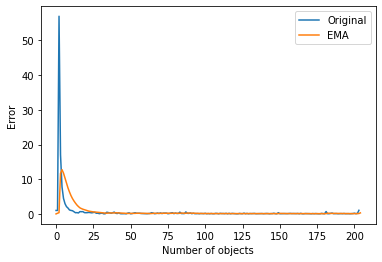

In [20]:
graf_l_taus(
    studySMAPE.best_trial.params['tau'],
    studySMAPE.best_trial.params['alpha'],
    studySMAPE.best_trial.params['step'],
    gradientSMAPE,
    SMAPE
)

In [21]:
studySMAPE = optuna.create_study(direction='minimize')
studySMAPE.optimize(lambda trial : objective_gradient(trial, gradientSMAPE, error_nrmse, SMAPE), n_trials=100)

print('Number of finished trials:', len(studySMAPE.trials))
print('Best trial:', studySMAPE.best_trial.params)
print('Best score:', studySMAPE.best_trial.value)

[I 2022-03-23 17:53:20,017] A new study created in memory with name: no-name-347aa26f-63ef-45cc-88bb-1c6f88ca7dea
[I 2022-03-23 17:53:20,136] Trial 0 finished with value: 0.1545736016594723 and parameters: {'tau': 4.967587562038855, 'alpha': 0.2982183741523622, 'step': 0.349021561420222}. Best is trial 0 with value: 0.1545736016594723.
[I 2022-03-23 17:53:20,142] Trial 1 finished with value: 0.6218650978146553 and parameters: {'tau': 0.091709225903438, 'alpha': 0.21314406322217821, 'step': 0.5230790376170444}. Best is trial 0 with value: 0.1545736016594723.
[I 2022-03-23 17:53:20,180] Trial 2 finished with value: 0.7826280629102171 and parameters: {'tau': 2.5701437707726607, 'alpha': 0.40968238736815743, 'step': 0.9029919104569712}. Best is trial 0 with value: 0.1545736016594723.
[I 2022-03-23 17:53:20,188] Trial 3 finished with value: 0.6218650978146553 and parameters: {'tau': 4.058186755497743, 'alpha': 0.5190933179355441, 'step': 0.004865284338124146}. Best is trial 0 with value: 0.

[I 2022-03-23 17:53:21,305] Trial 34 finished with value: 0.621465480020915 and parameters: {'tau': 3.8240674242227306, 'alpha': 0.38335208150674327, 'step': 0.1635117227333459}. Best is trial 4 with value: 0.05454416341723579.
[I 2022-03-23 17:53:21,329] Trial 35 finished with value: 0.6218650978146553 and parameters: {'tau': 0.014426143023571925, 'alpha': 0.2930923136305702, 'step': 0.262836889574089}. Best is trial 4 with value: 0.05454416341723579.
[I 2022-03-23 17:53:21,354] Trial 36 finished with value: 0.6218650978146553 and parameters: {'tau': 7.32709780425219, 'alpha': 0.1849566069968666, 'step': 0.008341254438278795}. Best is trial 4 with value: 0.05454416341723579.
[I 2022-03-23 17:53:21,389] Trial 37 finished with value: 0.6425367537595423 and parameters: {'tau': 3.384069862117258, 'alpha': 0.5577477152670964, 'step': 0.9942313083197448}. Best is trial 4 with value: 0.05454416341723579.
[I 2022-03-23 17:53:21,423] Trial 38 finished with value: 0.659972664441256 and paramete

[I 2022-03-23 17:53:23,154] Trial 68 finished with value: 0.670532182404229 and parameters: {'tau': 6.898608508473544, 'alpha': 0.6479996299213283, 'step': 0.4183214189961535}. Best is trial 67 with value: 0.039950334060502385.
[I 2022-03-23 17:53:23,271] Trial 69 finished with value: 0.0784052690510336 and parameters: {'tau': 5.313478139605189, 'alpha': 0.7621136883553115, 'step': 0.21630088900052083}. Best is trial 67 with value: 0.039950334060502385.
[I 2022-03-23 17:53:23,286] Trial 70 finished with value: 0.6215579363503859 and parameters: {'tau': 9.34886191416524, 'alpha': 0.601564033650464, 'step': 0.051407545356539075}. Best is trial 67 with value: 0.039950334060502385.
[I 2022-03-23 17:53:23,334] Trial 71 finished with value: 0.8377070424206238 and parameters: {'tau': 6.331746628610583, 'alpha': 0.6912388608009263, 'step': 0.1898684285886597}. Best is trial 67 with value: 0.039950334060502385.
[I 2022-03-23 17:53:23,352] Trial 72 finished with value: 0.621346762875372 and para

Number of finished trials: 100
Best trial: {'tau': 6.203728456396602, 'alpha': 0.5401750633540281, 'step': 0.1673198466574395}
Best score: 0.03817421889850621


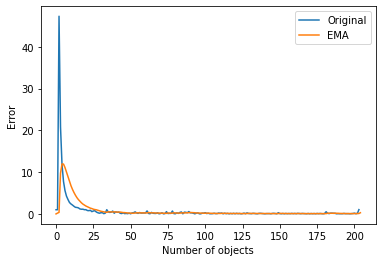

In [22]:
graf_l_taus(
    studySMAPE.best_trial.params['tau'],
    studySMAPE.best_trial.params['alpha'],
    studySMAPE.best_trial.params['step'],
    gradientSMAPE,
    SMAPE
)

In [23]:
studyMSE = optuna.create_study(direction='minimize')
studyMSE.optimize(lambda trial : objective_gradient(trial, gradientMSE, error_smape, MSE), n_trials=100)

print('Number of finished trials:', len(studyMSE.trials))
print('Best trial:', studyMSE.best_trial.params)
print('Best score:', studyMSE.best_trial.value)

[I 2022-03-23 17:54:32,486] A new study created in memory with name: no-name-a504c799-0644-4b3c-834e-60260906c8e5
[I 2022-03-23 17:54:32,923] Trial 0 finished with value: 99.999979820386 and parameters: {'tau': 7.104519272410639, 'alpha': 0.8817466208232474, 'step': 0.3601638970386092}. Best is trial 0 with value: 99.999979820386.
[I 2022-03-23 17:54:33,368] Trial 1 finished with value: 99.99985193011905 and parameters: {'tau': 4.298207989352887, 'alpha': 0.8192524037851093, 'step': 0.2727133537491413}. Best is trial 1 with value: 99.99985193011905.
[I 2022-03-23 17:54:33,790] Trial 2 finished with value: 100.0 and parameters: {'tau': 5.444213223898567, 'alpha': 0.2899035371970182, 'step': 0.8359517758218473}. Best is trial 1 with value: 99.99985193011905.
[I 2022-03-23 17:54:34,196] Trial 3 finished with value: 100.0 and parameters: {'tau': 2.6000691770144435, 'alpha': 0.29382392343690517, 'step': 0.5330308265991311}. Best is trial 1 with value: 99.99985193011905.
[I 2022-03-23 17:54:

[I 2022-03-23 17:54:43,846] Trial 34 finished with value: 11.540996372830344 and parameters: {'tau': 5.04330440156161, 'alpha': 0.5853888797520765, 'step': 0.04604508539753131}. Best is trial 31 with value: 10.136135080496858.
[I 2022-03-23 17:54:44,286] Trial 35 finished with value: 99.99996232393222 and parameters: {'tau': 4.5901518508270645, 'alpha': 0.5891127494043158, 'step': 0.3025056294248125}. Best is trial 31 with value: 10.136135080496858.
[I 2022-03-23 17:54:44,685] Trial 36 finished with value: 100.0 and parameters: {'tau': 5.129248331683517, 'alpha': 0.5217371154867296, 'step': 0.6009152593150642}. Best is trial 31 with value: 10.136135080496858.
[I 2022-03-23 17:54:45,110] Trial 37 finished with value: 99.97672349995528 and parameters: {'tau': 3.126064728688, 'alpha': 0.6980029883276062, 'step': 0.1993147015067303}. Best is trial 31 with value: 10.136135080496858.
[I 2022-03-23 17:54:45,138] Trial 38 finished with value: 13.48903189937894 and parameters: {'tau': 4.2737462

[I 2022-03-23 17:54:51,106] Trial 69 finished with value: 99.92963042934353 and parameters: {'tau': 6.5187205110878095, 'alpha': 0.12239097964058535, 'step': 0.22744870773156092}. Best is trial 54 with value: 7.640237211267159.
[I 2022-03-23 17:54:51,527] Trial 70 finished with value: 99.99989750635521 and parameters: {'tau': 6.169414341450279, 'alpha': 0.33126542682523635, 'step': 0.32530757671645194}. Best is trial 54 with value: 7.640237211267159.
[I 2022-03-23 17:54:51,544] Trial 71 finished with value: 10.321780597061124 and parameters: {'tau': 5.734925360866133, 'alpha': 0.31738300998825586, 'step': 0.030036711510176027}. Best is trial 54 with value: 7.640237211267159.
[I 2022-03-23 17:54:51,592] Trial 72 finished with value: 30.012455905441737 and parameters: {'tau': 5.742030684611548, 'alpha': 0.28619722790045476, 'step': 0.0685286856476606}. Best is trial 54 with value: 7.640237211267159.
[I 2022-03-23 17:54:51,610] Trial 73 finished with value: 7.881190612459105 and parameter

Number of finished trials: 100
Best trial: {'tau': 8.103511432194589, 'alpha': 0.27541878076020265, 'step': 0.037435687002126544}
Best score: 7.640237211267159


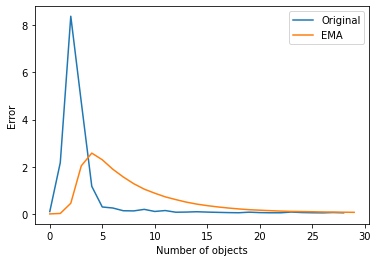

In [24]:
graf_l_taus(
    studyMSE.best_trial.params['tau'],
    studyMSE.best_trial.params['alpha'],
    studyMSE.best_trial.params['step'],
    gradientMSE,
    MSE
)

In [25]:
studyMSE = optuna.create_study(direction='minimize')
studyMSE.optimize(lambda trial : objective_gradient(trial, gradientMSE, error_nrmse, MSE), n_trials=100)

print('Number of finished trials:', len(studyMSE.trials))
print('Best trial:', studyMSE.best_trial.params)
print('Best score:', studyMSE.best_trial.value)

[I 2022-03-23 17:55:13,421] A new study created in memory with name: no-name-213341dd-e192-4e87-99e7-b1f72caacaac
[I 2022-03-23 17:55:13,834] Trial 0 finished with value: 2.4534142440859505e+18 and parameters: {'tau': 8.982604468782398, 'alpha': 0.872663801732885, 'step': 0.7531892825871591}. Best is trial 0 with value: 2.4534142440859505e+18.
[I 2022-03-23 17:55:14,234] Trial 1 finished with value: 2098090524806.7778 and parameters: {'tau': 9.717450673688719, 'alpha': 0.7935432122040974, 'step': 0.5786428446425189}. Best is trial 1 with value: 2098090524806.7778.
[I 2022-03-23 17:55:14,710] Trial 2 finished with value: 14492858035.948797 and parameters: {'tau': 7.052601846739454, 'alpha': 0.33578853112055107, 'step': 0.44431646761771315}. Best is trial 2 with value: 14492858035.948797.
[I 2022-03-23 17:55:14,858] Trial 3 finished with value: 1.193425609706008 and parameters: {'tau': 7.205874056452486, 'alpha': 0.4802385605723595, 'step': 0.09492651665216852}. Best is trial 3 with valu

[I 2022-03-23 17:55:23,264] Trial 34 finished with value: 0.25521505299850494 and parameters: {'tau': 7.953723847557844, 'alpha': 0.7739005625602898, 'step': 0.0653020799835564}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:23,664] Trial 35 finished with value: 3.332868945760866e+16 and parameters: {'tau': 8.710272852910965, 'alpha': 0.8541688750234578, 'step': 0.6950860410398668}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:24,067] Trial 36 finished with value: 39784248506421.75 and parameters: {'tau': 6.958700092169141, 'alpha': 0.7545116540360101, 'step': 0.545133319916341}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:24,472] Trial 37 finished with value: 4.770322917951089 and parameters: {'tau': 9.180519504024545, 'alpha': 0.8141846953710953, 'step': 0.1648908629136085}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:24,879] Trial 38 finished with value: 7964.804892292132 and paramet

[I 2022-03-23 17:55:31,464] Trial 68 finished with value: 0.6877494676366825 and parameters: {'tau': 7.973969191810241, 'alpha': 0.8678064812128172, 'step': 0.08508883942331613}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:31,503] Trial 69 finished with value: 0.0810586677348352 and parameters: {'tau': 6.726502861054521, 'alpha': 0.25787688265732006, 'step': 0.058075756553298136}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:31,979] Trial 70 finished with value: 1548.576892522143 and parameters: {'tau': 6.572737463019351, 'alpha': 0.21867622216821753, 'step': 0.21196336500778742}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:32,003] Trial 71 finished with value: 0.09796516278587392 and parameters: {'tau': 5.973058825709469, 'alpha': 0.25216688318197517, 'step': 0.056410259054837514}. Best is trial 31 with value: 0.07739924999433073.
[I 2022-03-23 17:55:32,042] Trial 72 finished with value: 0.3542055039103601 an

Number of finished trials: 100
Best trial: {'tau': 6.561331514993514, 'alpha': 0.849071091179926, 'step': 0.056849505277031184}
Best score: 0.07739924999433073


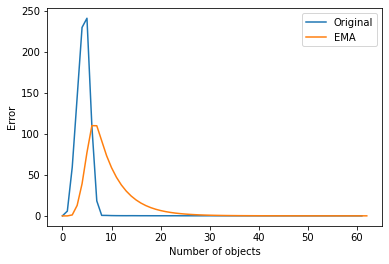

In [26]:
graf_l_taus(
    studyMSE.best_trial.params['tau'],
    studyMSE.best_trial.params['alpha'],
    studyMSE.best_trial.params['step'],
    gradientMSE,
    MSE
)

In [27]:
def least_squares_approximation(X, Y, tau):
    temp, _ = X.T.shape
    return np.linalg.inv(X.T @ X + np.identity(temp).dot(tau)) @ X.T @ Y

In [28]:
def objective_lsa(trial, error_function):
    tau = trial.suggest_uniform("tau", 1e-9, 1)

    w = least_squares_approximation(x_train, y_train, tau)

    return error_function(w)

In [29]:
studyLsa = optuna.create_study(direction='minimize')
studyLsa.optimize(lambda trial : objective_lsa(trial, error_smape), n_trials=100)

print('Number of finished trials:', len(studyLsa.trials))
print('Best trial:', studyLsa.best_trial.params)
print('Best score:', studyLsa.best_trial.value)

[I 2022-03-23 17:55:58,738] A new study created in memory with name: no-name-cd7dc991-280c-40e7-8c07-8afa3d655507
[I 2022-03-23 17:55:58,769] Trial 0 finished with value: 2.441771700968697 and parameters: {'tau': 0.23588308544537887}. Best is trial 0 with value: 2.441771700968697.
[I 2022-03-23 17:55:58,796] Trial 1 finished with value: 2.441811616656859 and parameters: {'tau': 0.3269789875712921}. Best is trial 0 with value: 2.441771700968697.
[I 2022-03-23 17:55:58,817] Trial 2 finished with value: 2.442861622573431 and parameters: {'tau': 0.9125380193783161}. Best is trial 0 with value: 2.441771700968697.
[I 2022-03-23 17:55:58,840] Trial 3 finished with value: 2.4417747696925 and parameters: {'tau': 0.2267892820792703}. Best is trial 0 with value: 2.441771700968697.
[I 2022-03-23 17:55:58,863] Trial 4 finished with value: 2.441773546253227 and parameters: {'tau': 0.26876246315302205}. Best is trial 0 with value: 2.441771700968697.
[I 2022-03-23 17:55:58,885] Trial 5 finished with v

[I 2022-03-23 17:55:59,787] Trial 45 finished with value: 2.4417783727656146 and parameters: {'tau': 0.21985832468566996}. Best is trial 20 with value: 2.4417703055788045.
[I 2022-03-23 17:55:59,807] Trial 46 finished with value: 2.44200288886379 and parameters: {'tau': 0.4710062900359266}. Best is trial 20 with value: 2.4417703055788045.
[I 2022-03-23 17:55:59,827] Trial 47 finished with value: 2.4417703901360706 and parameters: {'tau': 0.25303750018384524}. Best is trial 20 with value: 2.4417703055788045.
[I 2022-03-23 17:55:59,848] Trial 48 finished with value: 2.441822432217866 and parameters: {'tau': 0.3380816618447738}. Best is trial 20 with value: 2.4417703055788045.
[I 2022-03-23 17:55:59,870] Trial 49 finished with value: 2.4420456106023387 and parameters: {'tau': 0.12254754306314064}. Best is trial 20 with value: 2.4417703055788045.
[I 2022-03-23 17:55:59,892] Trial 50 finished with value: 2.4436895576511164 and parameters: {'tau': 0.042691189613957736}. Best is trial 20 with

[I 2022-03-23 17:56:00,746] Trial 90 finished with value: 2.4422250886917256 and parameters: {'tau': 0.100813147454271}. Best is trial 77 with value: 2.44177021742014.
[I 2022-03-23 17:56:00,765] Trial 91 finished with value: 2.4417703405714213 and parameters: {'tau': 0.25234368277325464}. Best is trial 77 with value: 2.44177021742014.
[I 2022-03-23 17:56:00,785] Trial 92 finished with value: 2.441784950046356 and parameters: {'tau': 0.21076939114102725}. Best is trial 77 with value: 2.44177021742014.
[I 2022-03-23 17:56:00,803] Trial 93 finished with value: 2.4417985793748898 and parameters: {'tau': 0.3119930869387169}. Best is trial 77 with value: 2.44177021742014.
[I 2022-03-23 17:56:00,823] Trial 94 finished with value: 2.441771430106491 and parameters: {'tau': 0.2605755855089982}. Best is trial 77 with value: 2.44177021742014.
[I 2022-03-23 17:56:00,843] Trial 95 finished with value: 2.441839062277233 and parameters: {'tau': 0.17407449985733398}. Best is trial 77 with value: 2.441

Number of finished trials: 100
Best trial: {'tau': 0.24895668909536303}
Best score: 2.44177021742014


In [30]:
studyLsa = optuna.create_study(direction='minimize')
studyLsa.optimize(lambda trial : objective_lsa(trial, error_nrmse), n_trials=100)

print('Number of finished trials:', len(studyLsa.trials))
print('Best trial:', studyLsa.best_trial.params)
print('Best score:', studyLsa.best_trial.value)

[I 2022-03-23 17:56:03,406] A new study created in memory with name: no-name-0c073c74-d5f4-45cd-bc8e-a29627602965
[I 2022-03-23 17:56:03,422] Trial 0 finished with value: 0.02352238267266621 and parameters: {'tau': 0.15899379607949532}. Best is trial 0 with value: 0.02352238267266621.
[I 2022-03-23 17:56:03,437] Trial 1 finished with value: 0.023527916939002122 and parameters: {'tau': 0.49144797652515504}. Best is trial 0 with value: 0.02352238267266621.
[I 2022-03-23 17:56:03,455] Trial 2 finished with value: 0.02353474144479634 and parameters: {'tau': 0.7160760368073406}. Best is trial 0 with value: 0.02352238267266621.
[I 2022-03-23 17:56:03,474] Trial 3 finished with value: 0.02352724499802409 and parameters: {'tau': 0.4676450794216238}. Best is trial 0 with value: 0.02352238267266621.
[I 2022-03-23 17:56:03,491] Trial 4 finished with value: 0.023523401517392854 and parameters: {'tau': 0.3121924168451616}. Best is trial 0 with value: 0.02352238267266621.
[I 2022-03-23 17:56:03,507]

[I 2022-03-23 17:56:04,381] Trial 44 finished with value: 0.02352267892816338 and parameters: {'tau': 0.2717986596386774}. Best is trial 22 with value: 0.023522038398396575.
[I 2022-03-23 17:56:04,405] Trial 45 finished with value: 0.023524642080170792 and parameters: {'tau': 0.3682150261999625}. Best is trial 22 with value: 0.023522038398396575.
[I 2022-03-23 17:56:04,425] Trial 46 finished with value: 0.023522048991706044 and parameters: {'tau': 0.19189138709987041}. Best is trial 22 with value: 0.023522038398396575.
[I 2022-03-23 17:56:04,443] Trial 47 finished with value: 0.023541393939415248 and parameters: {'tau': 0.03904047343254788}. Best is trial 22 with value: 0.023522038398396575.
[I 2022-03-23 17:56:04,465] Trial 48 finished with value: 0.02352342693871739 and parameters: {'tau': 0.12637678198297758}. Best is trial 22 with value: 0.023522038398396575.
[I 2022-03-23 17:56:04,485] Trial 49 finished with value: 0.023535591306815557 and parameters: {'tau': 0.7428309911092772}. 

[I 2022-03-23 17:56:05,248] Trial 88 finished with value: 0.023522439254716466 and parameters: {'tau': 0.15614902171592537}. Best is trial 56 with value: 0.023522038275220123.
[I 2022-03-23 17:56:05,268] Trial 89 finished with value: 0.023522801782565515 and parameters: {'tau': 0.2794775612747763}. Best is trial 56 with value: 0.023522038275220123.
[I 2022-03-23 17:56:05,287] Trial 90 finished with value: 0.023524436658222115 and parameters: {'tau': 0.35956027933846724}. Best is trial 56 with value: 0.023522038275220123.
[I 2022-03-23 17:56:05,307] Trial 91 finished with value: 0.02352203905908921 and parameters: {'tau': 0.19758496563224268}. Best is trial 56 with value: 0.023522038275220123.
[I 2022-03-23 17:56:05,328] Trial 92 finished with value: 0.02352214880248148 and parameters: {'tau': 0.17554224093870258}. Best is trial 56 with value: 0.023522038275220123.
[I 2022-03-23 17:56:05,349] Trial 93 finished with value: 0.023524763828600637 and parameters: {'tau': 0.1053859824647289}.

Number of finished trials: 100
Best trial: {'tau': 0.1998575579690669}
Best score: 0.023522038275220123


[Text(0.5, 0, 'tau'), Text(0, 0.5, 'error')]

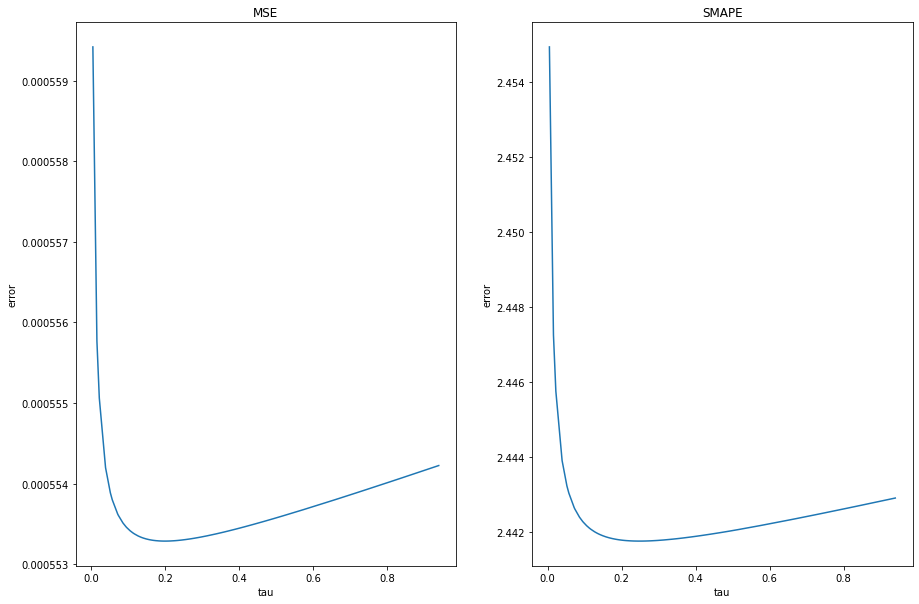

In [31]:
trials_lsa = sorted(studyLsa.trials_dataframe()['params_tau'].tolist())
predictions_mse = []
predictions_smape = []
for tau in trials_lsa:
    lsa = least_squares_approximation(x_train, y_train, tau)
    predictions_mse.append(error_mse(lsa))
    predictions_smape.append(error_smape(lsa))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(trials_lsa, predictions_mse)
ax2.plot(trials_lsa, predictions_smape)
ax1.set_title('MSE')
ax2.set_title('SMAPE')
ax1.set(xlabel='tau', ylabel='error')
ax2.set(xlabel='tau', ylabel='error')